In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import json

In [2]:
def plot_graph(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_' + string], '')
    plt.xlabel('Epochs')
    plt.ylabel(string)
    plt.legend([string, 'val_' + string])
    plt.show()

In [3]:
DATA_IN_PATH = './data_in/'
DATA_OUT_PATH = './data_out/'
INPUT_TRAIN_DATA = 'nsmc_train_input.npy'
LABEL_TRAIN_DATA = 'nsmc_train_label.npy'
DATA_CONFIGS = 'nsmc_data_configs.json'

In [4]:
SEED_NUM = 1234
tf.random.set_seed(SEED_NUM)

In [5]:
train_input = np.load(open(DATA_IN_PATH + INPUT_TRAIN_DATA, 'rb'))
train_label = np.load(open(DATA_IN_PATH + LABEL_TRAIN_DATA, 'rb'))
prepro_configs = json.load(open(DATA_IN_PATH + DATA_CONFIGS, 'r'))

In [6]:
model_name = 'cnn_classifier_kr'
BATCH_SIZE = 512
NUM_EPOCHS = 10
VALID_SPLIT = 0.1
MAX_LEN = train_input.shape[1]

kargs = {'model_name': model_name, 'vocab_size': prepro_configs['vocab_size'], 'embedding_size': 128, 'num_filters': 100, 
         'dropout_rate': 0.5, 'hidden_dimension': 250, 'output_dimension': 1}

In [7]:
class CNNClassifier(tf.keras.Model):
    def __init__(self, **kargs):
        super(CNNClassifier, self).__init__(name=kargs['model_name'])
        self.embedding = layers.Embedding(input_dim=kargs['vocab_size'] + 1, output_dim=kargs['embedding_size'])
        self.conv_list = [layers.Conv1D(filters=kargs['num_filters'], kernel_size=kernel_size, padding='valid', activation='relu', 
                                        kernel_constraint=tf.keras.constraints.MaxNorm(max_value=3.)) #커널 맥시멈 값을 지정해줌
                          for kernel_size in [3, 4, 5]]
        self.pooling = layers.GlobalMaxPooling1D()   #맥스풀링 전체사이즈 주는거 = 글로벌맥스풀링
        self.dropout = layers.Dropout(kargs['dropout_rate'])
        self.fc1 = layers.Dense(units=kargs['hidden_dimension'], activation='relu', kernel_constraint=tf.keras.constraints.MaxNorm(max_value=3.))
        self.fc2 = layers.Dense(units=kargs['output_dimension'], activation='sigmoid', kernel_constraint=tf.keras.constraints.MaxNorm(max_value=3.))
        
    def call(self, x):
        x = self.embedding(x)
        x = self.dropout(x)
        x = tf.concat([self.pooling(conv(x)) for conv in self.conv_list], axis=-1)
        x = self.fc1(x)
        x = self.fc2(x)
        
        return x

In [8]:
model = CNNClassifier(**kargs)
model.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.BinaryCrossentropy(), metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy')])

In [9]:
earlystop_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=2)
checkpoint_path = DATA_OUT_PATH + model_name + '/weights.h5'
checkpoint_dir = os.path.dirname(checkpoint_path)

if os.path.exists(checkpoint_dir):
    print('{} -- Folder already exists \n'.format(checkpoint_dir))
    
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print('{} -- Folder create complete \n'.format(checkpoint_dir))
    
cp_callback = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True)

./data_out/cnn_classifier_kr -- Folder create complete 



In [10]:
history = model.fit(train_input, train_label, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, validation_split=VALID_SPLIT, callbacks=[earlystop_callback, cp_callback])

Epoch 1/10
263/264 [============================>.] - ETA: 0s - loss: 0.4584 - accuracy: 0.7758
Epoch 00001: val_accuracy improved from -inf to 0.82140, saving model to ./data_out/cnn_classifier_kr\weights.h5
264/264 [==============================] - 14s 55ms/step - loss: 0.4582 - accuracy: 0.7759 - val_loss: 0.3955 - val_accuracy: 0.8214
Epoch 2/10
263/264 [============================>.] - ETA: 0s - loss: 0.3518 - accuracy: 0.8452
Epoch 00002: val_accuracy improved from 0.82140 to 0.82873, saving model to ./data_out/cnn_classifier_kr\weights.h5
264/264 [==============================] - 14s 54ms/step - loss: 0.3517 - accuracy: 0.8452 - val_loss: 0.3850 - val_accuracy: 0.8287
Epoch 3/10
263/264 [============================>.] - ETA: 0s - loss: 0.2999 - accuracy: 0.8730
Epoch 00003: val_accuracy did not improve from 0.82873
264/264 [==============================] - 14s 54ms/step - loss: 0.2999 - accuracy: 0.8730 - val_loss: 0.3995 - val_accuracy: 0.8217
Epoch 4/10
263/264 [=========

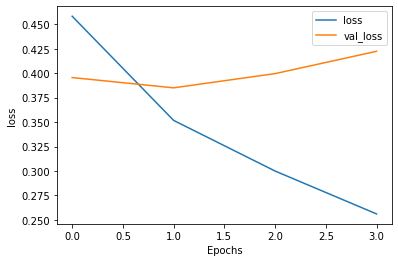

In [12]:
plot_graph(history, 'loss')

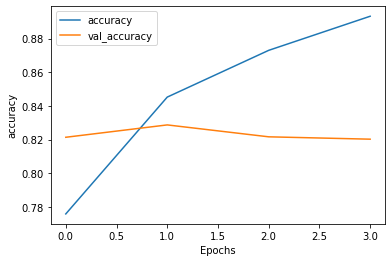

In [13]:
plot_graph(history, 'accuracy')

In [16]:
INPUT_TEST_DATA = 'nsmc_test_input.npy'
LABEL_TEST_DATA = 'nsmc_test_label.npy'
SAVE_FILE_NM = 'weights.h5'

test_input = np.load(open(DATA_IN_PATH + INPUT_TEST_DATA, 'rb'))
test_label_data = np.load(open(DATA_IN_PATH + LABEL_TEST_DATA, 'rb'))

In [17]:
model.load_weights(os.path.join(DATA_OUT_PATH, model_name, SAVE_FILE_NM))

In [18]:
model.evaluate(test_input, test_label_data)

1563/1563 [==============================] - 1s 909us/step - loss: 0.3875 - accuracy: 0.8257


[0.38751885294914246, 0.8257200121879578]